# Introduction

Our ultimate aim is to predict solar electricity power generation over the next few hours.

## Loading terabytes of data efficiently from cloud storage

We have several TB of satellite data. To keep the GPU fed with data during training, we need to read chunks of data quickly from the Zarr store; and we also want to load data asynchronously.  That is, while the GPU is training on the current batch, the data loader should simultaneously load the _next_ batch from disk.

PyTorch makes this easy!  PyTorch's `DataLoader` spawns multiple worker processes when constructed with `num_workers` set to more than 1.  Each worker process receives a copy of the `SatelliteDataset` object.

There is a small challenge: The code hangs when it gets to `enumerate(dataloader)` if we open the `xarray.DataArray` in the main process and copy that opened `DataArray` to the child processes.  Our solution is to delay the creation of the `DataArray` until _after_ the worker processes have been created.  PyTorch makes this easy by allowing us to pass a `worker_init_fn` to `DataLoader`.  `worker_init_fn` is called on each worker process.  Our `worker_init_fn` just has one job: to call `SatelliteDataset.per_worker_init()` which, in turn, opens the `DataArray`.

This approach achieves read speeds of 600 MB/s from Google Cloud Storage to a single GCP VM with 12 vCPUs (as measured by `nethogs`).

We use `IterableDataset` instead of `Dataset` so `SatelliteDataset` can pre-load the next example from disk and then block (on the `yield`) waiting for PyTorch to read that data.  This allows the worker processes to be processing the next data samples while the main process is training the current batch on the GPU.

We can't pin the memory in each worker process because pinned memory can't be shared across processes.  Instead we ask `DataLoader` to pin the collated batch so that pytorch-lightning can asynchronously load the next batch from pinned CPU memory into GPU memory.

The satellite data is stored on disk as `int16`.  To speed up the movement of the satellite data between processes and from the CPU memory to the GPU memory, we keep the data as `int16` until the data gets to the GPU, where it is converted to `float32` and normalised.

### Loading data from disk into memory in chunks

Cloud storage buckets can't seek into files like 'proper' POSIX filesystems can.  So, even if we just want 1 byte from a 1 GB file, we have to load the entire 1 GB file from the bucket.

Zarr is designed with this challenge in mind.  Zarr gets round the inability of cloud storage buckets to seek by chunking the data into lots of small files.  But, still, we have to load entire Zarr chunks at once, even if we only want a part of a chunk.  And, even though we can pull 600 MB/s from a cloud storage bucket, the reads from the storage bucket are still the rate-limiting-step.  (GPUs are very fast and have a voracious appetite for data!)

To get the most out of each disk read, our worker processes load several contiguous chunks of Zarr data from disk into memory at once.  We then randomly sample from the in-memory data multiple times, before loading another set of chunks from disk into memory.   This trick increases training speed by about 10x.

Each Zarr chunk is 36 timesteps long and contains the entire geographical extent.  Each timestep is about 5 minutes apart, so each Zarr chunk spans 1.5 hours, assuming the timesteps are contiguous (more on contiguous chunks later).

### Loading only daylight data

We're interested in forecasting solar power generation, so we don't care about nighttime data :)

In the UK in summer, the sun rises first in the north east, and sets last in the north west (see [video of June 2019](https://www.youtube.com/watch?v=IOp-tj-IJpk&t=0s)).  In summer, the north gets more hours of sunshine per day.

In the UK in winter, the sun rises first in the south east, and sets last in the south west (see [video of Jan 2019](https://www.youtube.com/watch?v=CJ4prUVa2nQ)).  In winter, the south gets more hours of sunshine per day.

|                        | Summer | Winter |
|           ---:         |  :---: |  :---: |
| Sun rises first in     | N.E.   | S.E.   |
| Sun sets last in       | N.W.   | S.W.   |
| Most hours of sunlight | North  | South  |

We always load a pre-defined number of Zarr chunks from disk every disk load (defined by `n_chunks_per_disk_load`).

Before training, we select timesteps which have at least some sunlight.  We do this by computing the clearsky global horizontal irradiance (GHI) for the four corners of the satellite imagery, and for all the timesteps in the dataset.  We only use timesteps where the maximum global horizontal irradiance across all four corners is above some threshold.

(The 'clearsky [solar irradiance](https://en.wikipedia.org/wiki/Solar_irradiance)' is the amount of sunlight we'd expect on a clear day at a specific time and location. The SI unit of irradiance is watt per square meter.  The 'global horizontal irradiance' is the total sunlight that would hit a horizontal surface on the surface of the Earth.  The GHI is the sum of the direct irradiance (sunlight which takes a direct path from the Sun to the Earth's surface) and the diffuse horizontal irradiance (the sunlight scattered from the atmosphere)).

### Finding contiguous sequences

Once we have a list of 'lit' timesteps, we then find contiguous sequences (timeseries without any gaps).  And we then compute a list of contiguous Zarr chunks that we'll load at once during training.

### Loading data during training

During training, each worker process randomly picks multiple contiguous Zarr chunk sequences from the list of contiguous sequences pre-computed before training started.  The worker loads that data into memory and then randomly samples many samples from that in-memory data before loading more data from disk.

#### Ensuring each batch contains a random sample of the dataset

When PyTorch's `DataLoader` constructs a batch, it reads from just one worker process.  (This is not how I had _assumed_ it would work:  I assumed PyTorch would construct each batch by randomly sampling from all workers.)  This is an issue because, for stochastic gradient descent to work correctly, each batch must contain random samples of the dataset.  So it's not sufficient for each worker to load just one contiguous Zarr chunk (because then each batch would be made up entirely of samples from roughly the same time of day).  So, instead, each worker process loads multiple contiguous Zarr sequences into memory.  This also means that each worker must load quite a lot of data from disk.  To avoid training pausing while a worker process loads more data from disk, the data loading is done asynchronously using a separate thread within each worker process.

# Conventions

## Timestamps

All timeseries data is converted to UTC (if necessary), and then converted to timezone-naive timestamps (to simplify downstream code)

## Timestep numbering:

* t<sub>0</sub> is 'now': the most recent observation.
* t<sub>1</sub> is the first timestep of the forecast.

In [1]:
# Python core
from typing import Optional, Callable, TypedDict, Union, Iterable, Tuple, NamedTuple, List
from dataclasses import dataclass
import datetime
from itertools import product
from concurrent import futures
from pathlib import Path
import numbers
import threading

# Scientific python
import numpy as np
import pandas as pd
import xarray as xr
import numcodecs
import matplotlib.pyplot as plt
import dask

# Cloud compute
import gcsfs
import fsspec

# PyTorch
import torch
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl

# PV & geospatial
import pvlib
import pyproj

In [2]:
threading.active_count()

5

In [3]:
xr.__version__

'0.18.0'

In [4]:
gcsfs.__version__

'2021.05.0'

In [5]:
fsspec.__version__

'2021.05.0'

In [6]:
torch.__version__

'1.8.1'

In [7]:
torch.cuda.is_available()

True

In [8]:
pyproj.__version__

'3.0.1'

## Consts & config

The [Zarr docs](https://zarr.readthedocs.io/en/stable/tutorial.html#configuring-blosc) say we should tell the Blosc compression library not to use threads because we're using multiple processes to read from our Zarr store:

In [9]:
numcodecs.blosc.use_threads = False

plt.rcParams['figure.figsize'] = (25, 10)
plt.rcParams['image.interpolation'] = 'none'

In [10]:
BUCKET = Path('solar-pv-nowcasting-data')

# Satellite data
SAT_DATA_ZARR = BUCKET / 'satellite/EUMETSAT/SEVIRI_RSS/OSGB36/all_zarr_int16'

# Solar PV data
PV_PATH = BUCKET / 'PV/PVOutput.org'
PV_DATA_FILENAME = PV_PATH / 'UK_PV_timeseries_batch.nc'
PV_METADATA_FILENAME = PV_PATH / 'UK_PV_metadata.csv'

# Numerical weather predictions
NWP_ZARR = BUCKET / 'NWP/UK_Met_Office/UKV_zarr'

In [11]:
PV_DATA_FILENAME

PosixPath('solar-pv-nowcasting-data/PV/PVOutput.org/UK_PV_timeseries_batch.nc')

In [12]:
def open_zarr_on_gcp(filename: Union[str, Path]=SAT_DATA_ZARR, consolidated: bool=True) -> xr.DataArray:
    """Lazily opens the Zarr store on Google Cloud Storage (GCS)."""
    # Clear reference to the loop and thread.  This is necessary otherwise
    # gcsfs hangs in the ML training loop.
    # See https://github.com/dask/gcsfs/issues/379#issuecomment-839929801
    # Only relevant for fsspec >= 0.9.0
    fsspec.asyn.iothread[0] = None
    fsspec.asyn.loop[0] = None
    
    gcs = gcsfs.GCSFileSystem(
        access='read_only', 
        # skip_instance_cache=True  # Why skip_instance_cache?  See https://github.com/dask/gcsfs/issues/379#issuecomment-839929801
    )
    
    store = gcsfs.GCSMap(root=filename, gcs=gcs)
    dataset = xr.open_zarr(store, consolidated=consolidated)
    return dataset

# Load satellite data

In [13]:
def open_sat_data(filename: Union[str, Path]=SAT_DATA_ZARR) -> xr.DataArray:
    """Lazily opens the Zarr store on Google Cloud Storage (GCS).
    
    Selects the High Resolution Visible (HRV) satellite channel.
    """
    # TODO: Maybe add 1 minute to data_array.time from the get-go, to simplify alignment with PV data?
    
    dataset = open_zarr_on_gcp(filename)
    data_array = dataset['stacked_eumetsat_data'].sel(variable='HRV')
    # The 'time' dimension is at 04, 09, ..., 59 minutes past the hour.  To make it easier
    # to align the satellite data with other data sources (which are at 00, 05, ..., 55 minutes past the hour),
    # add 1 minute to the time dimension.
    data_array['time'] = data_array.time + pd.Timedelta('1 minute')
    return data_array

In [14]:
%%time
sat_data = open_sat_data()

CPU times: user 1.97 s, sys: 53.2 ms, total: 2.03 s
Wall time: 2.77 s


Caution: Wierdly, plotting `sat_data` at this point causes the code to hang (with no errors messages) when it gets to `for batch in dataloader:`.  The code hangs even if we first do `sat_data.close(); del sat_data`.  See https://github.com/dask/gcsfs/issues/379

Get the datetime boundaries of each Zarr chunk.  Later, we will use these boundaries to ensure we load complete chunks at a time.

In [15]:
# First, get the integer indicies of the chunk boundaries.
zarr_chunk_boundaries = np.concatenate(([0], np.cumsum(sat_data.chunks[0])))

# Then convert to datetimes.  Except the last one, because that's one-out-of-range.
zarr_chunk_boundaries = pd.DatetimeIndex(
    np.concatenate((sat_data['time'].values[zarr_chunk_boundaries[:-1]], sat_data['time'].values[-1:])))

assert zarr_chunk_boundaries[-2] != zarr_chunk_boundaries[-1]

zarr_chunk_boundaries

DatetimeIndex(['2018-06-01 02:05:00', '2018-06-01 05:05:00',
               '2018-06-01 08:05:00', '2018-06-01 11:05:00',
               '2018-06-01 14:05:00', '2018-06-01 17:05:00',
               '2018-06-01 20:05:00', '2018-06-01 23:05:00',
               '2018-06-02 02:55:00', '2018-06-02 05:55:00',
               ...
               '2019-12-30 20:05:00', '2019-12-30 23:05:00',
               '2019-12-31 02:05:00', '2019-12-31 05:05:00',
               '2019-12-31 08:05:00', '2019-12-31 11:05:00',
               '2019-12-31 14:05:00', '2019-12-31 17:05:00',
               '2019-12-31 20:05:00', '2019-12-31 22:55:00'],
              dtype='datetime64[ns]', length=4531, freq=None)

## Select daylight hours

In [16]:
# OSGB is also called "OSGB 1936 / British National Grid -- United Kingdom Ordnance Survey".
# OSGB is used in many UK electricity system maps, and is used by the UK Met Office UKV model.
# OSGB is a Transverse Mercator projection, using 'easting' and 'northing' coordinates
# which are in meters.
OSGB = 27700

# WGS84 is short for "World Geodetic System 1984", used in GPS. Uses latitude and longitude.
WGS84 = 4326

# osgb_to_wgs84.transform(x, y) returns latitude (north-south), longitude (east-west)
osgb_to_wgs84 = pyproj.Transformer.from_crs(crs_from=OSGB, crs_to=WGS84)

# wgs84_to_osgb.transform(lat, lon) returns x, y
wgs84_to_osgb = pyproj.Transformer.from_crs(crs_from=WGS84, crs_to=OSGB)

def select_daylight_timestamps(
    dt_index: pd.DatetimeIndex, 
    locations: Iterable[Tuple[float, float]],
    ghi_threshold: float = 10
    ) -> pd.DatetimeIndex:
    """Returns sat_datetimes for which the global horizontal irradiance
    (GHI) is above ghi_threshold across all locations.

    Args:
      dt_index: DatetimeIndex to filter.
      locations: List of Tuples of x, y coordinates in OSGB projection.
      ghi_threshold: Global horizontal irradiance threshold.  (Watts per square meter?)
    """
    ghi_for_all_locations = []
    for x, y in locations:
        lat, lon = osgb_to_wgs84.transform(x, y)
        location = pvlib.location.Location(latitude=lat, longitude=lon)
        clearsky = location.get_clearsky(dt_index)
        ghi = clearsky['ghi']
        ghi_for_all_locations.append(ghi)
        
    ghi_for_all_locations = pd.concat(ghi_for_all_locations, axis='columns')
    max_ghi = ghi_for_all_locations.max(axis='columns')
    mask = max_ghi > ghi_threshold
    return dt_index[mask]

In [17]:
lat, lon = osgb_to_wgs84.transform(100_000, 50_000)
lat, lon

(50.27355046969303, -6.2118783381825775)

In [18]:
x, y = wgs84_to_osgb.transform(lat, lon)
x, y

(100000.00054720748, 49999.99933833117)

In [19]:
# Get 'corner' coordinates for a rectange GEO_BORDER within the actual boundary of the satellite imagery.
GEO_BORDER: int = 64  #: In same geo projection and units as sat_data.
corners = [
    (sat_data.x.values[x], sat_data.y.values[y]) 
    for x, y in product(
        [GEO_BORDER, -GEO_BORDER], 
        [GEO_BORDER, -GEO_BORDER])]

In [20]:
%%time
sat_datetimes = select_daylight_timestamps(
    dt_index=pd.DatetimeIndex(sat_data.time.values), 
    locations=corners)

CPU times: user 6.86 s, sys: 84.6 ms, total: 6.94 s
Wall time: 7.66 s


In [21]:
len(sat_datetimes)

89098

In [22]:
#sat_data.close()
#del sat_data

# Load PV power timeseries data

In [23]:
%%time
pv_metadata = pd.read_csv(f'gs://{PV_METADATA_FILENAME}', index_col='system_id')
pv_metadata.dropna(subset=['longitude', 'latitude'], how='any', inplace=True)

CPU times: user 20.4 ms, sys: 8.25 ms, total: 28.6 ms
Wall time: 217 ms


In [24]:
pv_metadata

,system_name,system_size_watts,postcode,number_of_panels,panel_power_watts,panel_brand,num_inverters,inverter_power_watts,inverter_brand,orientation,array_tilt_degrees,shade,install_date,latitude,longitude,status_interval_minutes,number_of_panels_secondary,panel_power_watts_secondary,orientation_secondary,array_tilt_degrees_secondary
system_id,,,,,,,,,,,,,,,,,,,,
19397,AndyT's,3900,BS22,20,195,ZN Shine 195w,1,3500,Kaco 4202,S,30.0,No,2011-11-21 00:00:00,51.360000,-2.920000,5,0,0,NaN,NaN
8195,Kilmarnock Roof,3750,KA3,15,250,Sanyo 250 HIT,1,4000,Omniksol,S,30.0,No,2011-11-07 00:00:00,55.640000,-4.490000,10,0,0,NaN,NaN
8200,Flat 5,3430,E8,14,245,NaN,1,3000,sb3000,S,25.0,Low,2011-12-12 00:00:00,51.540000,-0.060000,5,0,0,NaN,NaN
8204,Sooper-Dooper Solar,2940,GU2,12,245,SunTech STP245S-20/Wd,1,3000,Kaco Powador 3002,S,19.0,No,2012-05-11 00:00:00,51.240000,-0.590000,10,0,0,NaN,NaN
8205,58GPR,4000,BS48,16,250,Sanyo component Europe GmbH,1,50,Sma sunny boysb3800v,S,NaN,No,2011-11-10 00:00:00,51.420000,-2.740000,10,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8164,Bradwell,49950,NR31,222,225,Canadaian Solar CSP6P,3,17000,SMA STPxx000TL,S,25.0,No,2012-03-01 00:00:00,52.570000,1.710000,15,0,0,NaN,NaN
40941,The Tavi Generators,2600,PL19,10,260,Don't know,1,3000,SMA S3000,S,1.0,Low,2014-05-20 00:00:00,50.550000,-4.150000,5,0,0,NaN,NaN
40943,Allen's,3990,PE37,14,285,Seraphim SRP-285-5MA-BF,1,4000,SolarEdge SE4000-16A,SW,30.0,No,2015-04-10 00:00:00,52.645921,0.778089,5,0,0,NaN,NaN


In [25]:
pv_metadata['location_x'], pv_metadata['location_y'] = wgs84_to_osgb.transform(pv_metadata['latitude'], pv_metadata['longitude'])

In [26]:
# Remove PV systems outside of the geospatial extent of the satellite data
GEOSPATIAL_BOUNDARY = {
    'WEST': sat_data.x.values[0],
    'EAST': sat_data.x.values[-1],
    'NORTH': sat_data.y.values[0],
    'SOUTH': sat_data.y.values[-1]}

In [27]:
GEOSPATIAL_BOUNDARY

{'WEST': -238000, 'EAST': 856000, 'NORTH': 1222000, 'SOUTH': -184000}

In [28]:
pv_metadata = pv_metadata[
    (pv_metadata.location_x >= GEOSPATIAL_BOUNDARY['WEST']) &
    (pv_metadata.location_x <= GEOSPATIAL_BOUNDARY['EAST']) &
    (pv_metadata.location_y <= GEOSPATIAL_BOUNDARY['NORTH']) &
    (pv_metadata.location_y >= GEOSPATIAL_BOUNDARY['SOUTH'])]

In [29]:
import io

In [30]:
def load_solar_pv_data(start_datetime, end_datetime) -> pd.DataFrame:
    gcs = gcsfs.GCSFileSystem(access='read_only')

    # It is possible to simplify the code below and do the xr.open_dataset(file) in
    # the first 'with' block, and delete the second 'with' block.  But that takes 6 minutes to load the data, 
    # where as loading into memory first and then loading from there takes 23 seconds!
    with gcs.open(PV_DATA_FILENAME, mode='rb') as file:
        file_bytes = file.read()

    with io.BytesIO(file_bytes) as file:
        pv_power = xr.open_dataset(file)
        pv_power_df = pv_power.sel(datetime=slice(start_datetime, end_datetime)).to_dataframe()

    # Save memory
    del file_bytes    
    del pv_power
    
    # Tidy up
    gcs.clear_instance_cache()  # See https://github.com/dask/gcsfs/issues/379#issuecomment-826930203
    
    # Process the data a little
    pv_power_df = pv_power_df.dropna(axis='columns', how='all')
    pv_power_df = pv_power_df.clip(lower=0, upper=5E7)
    pv_power_df.columns = [np.int32(col) for col in pv_power_df.columns]    
    return pv_power_df.tz_localize('Europe/London').tz_convert('UTC').tz_convert(None)

In [31]:
%%time
# Clip to start and end date of satellite data.
pv_power_df = load_solar_pv_data(start_datetime=sat_datetimes[0], end_datetime=sat_datetimes[-1])

CPU times: user 20.8 s, sys: 1.96 s, total: 22.7 s
Wall time: 23.8 s


In [32]:
pv_power_df

,10003,10012,10020,10033,10041,10078,10156,10334,10427,10493,...,9464,9570,9647,973,9741,9750,9785,9807,9831,9860
datetime,,,,,,,,,,,,,,,,,,,,,
2018-06-01 02:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-01 02:35:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-01 02:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-01 02:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-01 02:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-20 21:40:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-20 21:45:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-20 21:50:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='datetime'>

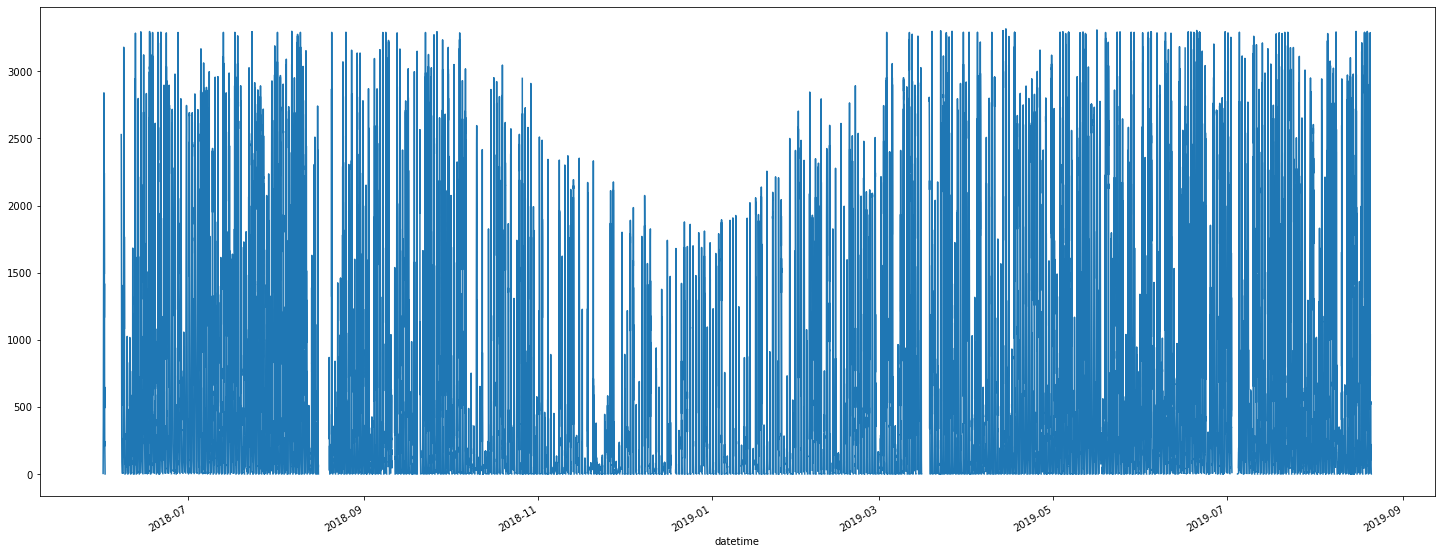

In [33]:
pv_power_df[10003].plot()

In [34]:
pv_power_df.values.nbytes / 1E9

0.40121268

In [35]:
# A bit of hand-crafted cleaning
pv_power_df[30248]['2018-10-29':'2019-01-03'] = np.NaN

In [36]:
# Only pick PV systems for which we have metadata.
def align_pv_system_ids(pv_metadata, pv_power_df):
    pv_system_ids = pv_metadata.index.intersection(pv_power_df.columns)
    pv_system_ids = np.sort(pv_system_ids)

    pv_power_df = pv_power_df[pv_system_ids]
    pv_metadata = pv_metadata.loc[pv_system_ids]
    return pv_metadata, pv_power_df
    
pv_metadata, pv_power_df = align_pv_system_ids(pv_metadata, pv_power_df)

In [37]:
len(pv_metadata)

952

In [38]:
# Scale to the range [0, 1]
pv_power_min = pv_power_df.min()
pv_power_df -= pv_power_min
pv_power_max = pv_power_df.max()
pv_power_df /= pv_power_max

In [39]:
pv_power_df.min().min()

0.0

In [40]:
# Drop systems which produce power over night
NIGHT_YIELD_THRESHOLD = 0.4
night_hours = [22, 23, 0, 1, 2]
pv_data_at_night = pv_power_df.loc[pv_power_df.index.hour.isin(night_hours)]
pv_above_threshold_at_night = (pv_data_at_night > NIGHT_YIELD_THRESHOLD).any()
bad_systems = pv_power_df.columns[pv_above_threshold_at_night]
print(len(bad_systems), 'bad systems found.')

12 bad systems found.


In [41]:
# TODO: Of these bad systems, 24647, 42656, 42807, 43081, 51247, 59919 might have some salvagable data?

In [42]:
pv_power_df = pv_power_df.drop(columns=bad_systems)

In [43]:
%%time
# Resample to 5-minutely and interpolate up to 15 minutes ahead.
pv_power_df = pv_power_df.resample('5T').interpolate(method='time', limit=3)

CPU times: user 27.7 s, sys: 2.26 s, total: 30 s
Wall time: 30 s


<AxesSubplot:xlabel='datetime'>

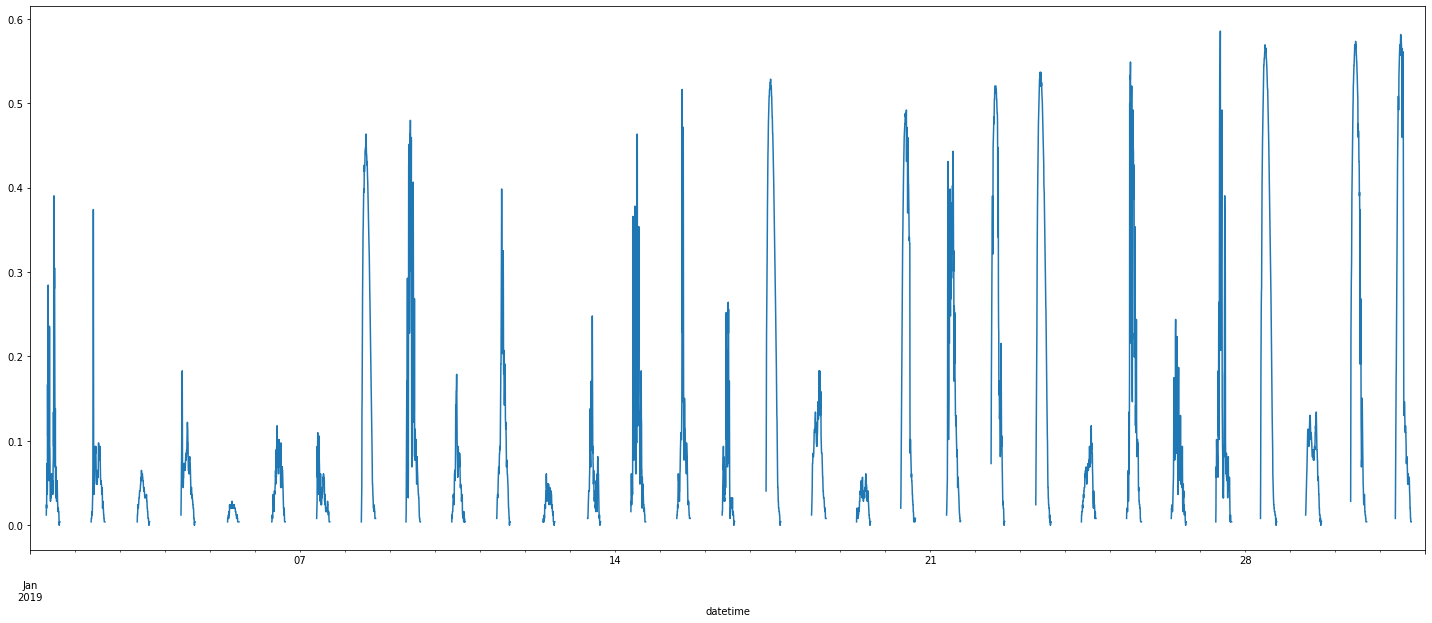

In [44]:
pv_power_df[pv_power_df.columns[5]]['2019-01'].plot()

In [45]:
# Align again, after removing dud PV systems
pv_metadata, pv_power_df = align_pv_system_ids(pv_metadata, pv_power_df)
len(pv_power_df.columns)

940

In [46]:
len(pv_power_df)

128395

In [47]:
sat_datetimes = pv_power_df.index.intersection(sat_datetimes)

In [48]:
len(sat_datetimes)

72385

In [49]:
pv_power_df.values.nbytes / 1E6

482.7652

In [50]:
# Minimum number of PV systems available for one timestep:
(~pv_power_df.isna()).sum(axis='columns').min()

0

# Load numerical weather predictions

In [51]:
def open_nwp(base_path: Path=NWP_ZARR) -> xr.Dataset:
    nwp_datasets = []
    for zarr_store in ['2018_1-6', '2018_7-12', '2019_1-6', '2019_7-12']:
        full_dir = base_path / zarr_store
        ds = open_zarr_on_gcp(full_dir)
        ds = ds.rename({'time': 'init_time'})
        # The isobaricInhPa coordinates look messed up, especially in the 2018_7-12 and 2019_7-12 Zarr stores.
        # So let's drop all the variables with multiple vertical levels for now:
        del ds['isobaricInhPa'], ds['gh_p'], ds['r_p'], ds['t_p'], ds['wdir_p'], ds['ws_p']
        nwp_datasets.append(ds)

    # Concat.
    dask.config.set({"array.slicing.split_large_chunks": False})  # Silence warning about large chunks
    nwp = xr.concat(nwp_datasets, dim='init_time')
    del nwp_datasets  # Save a little memory.
    
    # There are a lot of doubled-up indicies from 2018-07-18 00:00 to 2018-08-27 09:00.
    # De-duplicate the index. Code adapted from https://stackoverflow.com/a/51077784/732596
    _, unique_index = np.unique(nwp.init_time, return_index=True)
    return nwp.isel(init_time=unique_index)

In [52]:
%%time
nwp = open_nwp()

CPU times: user 7.7 s, sys: 491 ms, total: 8.19 s
Wall time: 14 s


In [53]:
# Get names of the NWP variables

nwp_var_names = [var_name for var_name, _ in nwp.variables.items()]

nwp_var_details = pd.DataFrame(columns=['name', 'units'], index=nwp_var_names)
for var_name, var in nwp.variables.items():
    attrs = var.attrs
    if 'stanard_name' in attrs:
        name = attrs['standard_name']
    elif 'long_name' in attrs:
        name = attrs['long_name']
    else:
        name = ''
        
    try:
        units = var.attrs['units']
    except:
        units = ''
    nwp_var_details.loc[var_name] = {'name': name, 'units': units}
    
nwp_var_details

,name,units
cdcb,Cloud base,m
dlwrf,Downward long-wave radiation flux,W m**-2
dpt,Dew point temperature,K
dswrf,Downward short-wave radiation flux,W m**-2
gust10,Wind speed (gust),m s**-1
gust10_m,Wind speed (gust),m s**-1
h,Geometrical height,m
hcc,High cloud cover,%
hcct,Height of convective cloud top,m
lcc,Low cloud cover,%


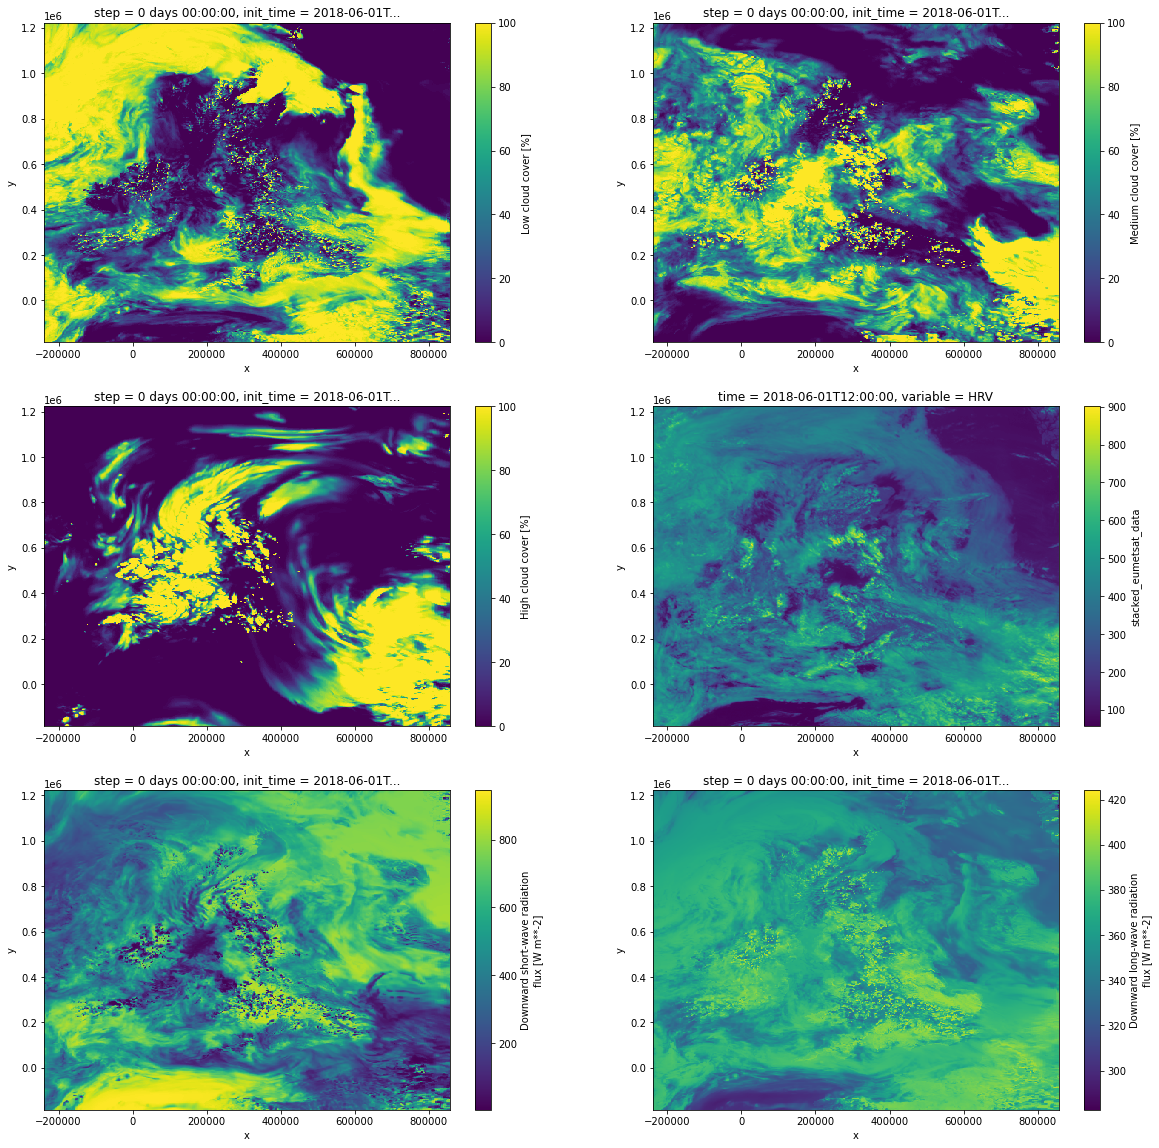

In [54]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))

ax = axes[0][0]
nwp['lcc'].sel(init_time='2018-06-01T12:00').isel(step=0).clip(0).plot(ax=ax)

ax = axes[0][1]
nwp['mcc'].sel(init_time='2018-06-01T12:00').isel(step=0).clip(0).plot(ax=ax)

ax = axes[1][0]
nwp['hcc'].sel(init_time='2018-06-01T12:00').isel(step=0).clip(0).plot(ax=ax)

ax = axes[1][1]
sat_data.sel(time='2018-06-01T12:00').plot(ax=ax)

ax = axes[2][0]
nwp['dswrf'].sel(init_time='2018-06-01T12:00').isel(step=0).plot(ax=ax)

ax = axes[2][1]
nwp['dlwrf'].sel(init_time='2018-06-01T12:00').isel(step=0).plot(ax=ax);

In [55]:
%%time
# Get full set of available target_times for NWPs
# (to be used later to pre-compute which datetimes are available for training)

MAX_STEP = 3
nwp_target_times = nwp['init_time'] + nwp['step'][:MAX_STEP]
nwp_target_times = nwp_target_times.values.flatten()
nwp_target_times = np.unique(nwp_target_times)
nwp_target_times = np.sort(nwp_target_times)
nwp_target_times = pd.DatetimeIndex(nwp_target_times)
resampler = pd.Series(0, index=nwp_target_times).resample('5T')
nwp_target_times = resampler.ffill(limit=11).dropna().index

CPU times: user 9.34 ms, sys: 127 µs, total: 9.47 ms
Wall time: 79.2 ms


In [56]:
nwp_target_times[
    (nwp_target_times >= pd.Timestamp('2018-08-01T00:00')) &
    (nwp_target_times <= pd.Timestamp('2018-08-02T00:00'))
]

DatetimeIndex(['2018-08-01 12:00:00', '2018-08-01 12:05:00',
               '2018-08-01 12:10:00', '2018-08-01 12:15:00',
               '2018-08-01 12:20:00', '2018-08-01 12:25:00',
               '2018-08-01 12:30:00', '2018-08-01 12:35:00',
               '2018-08-01 12:40:00', '2018-08-01 12:45:00',
               '2018-08-01 12:50:00', '2018-08-01 12:55:00',
               '2018-08-01 13:00:00', '2018-08-01 13:05:00',
               '2018-08-01 13:10:00', '2018-08-01 13:15:00',
               '2018-08-01 13:20:00', '2018-08-01 13:25:00',
               '2018-08-01 13:30:00', '2018-08-01 13:35:00',
               '2018-08-01 13:40:00', '2018-08-01 13:45:00',
               '2018-08-01 13:50:00', '2018-08-01 13:55:00',
               '2018-08-01 14:00:00', '2018-08-01 14:05:00',
               '2018-08-01 14:10:00', '2018-08-01 14:15:00',
               '2018-08-01 14:20:00', '2018-08-01 14:25:00',
               '2018-08-01 14:30:00', '2018-08-01 14:35:00',
               '2018-08-

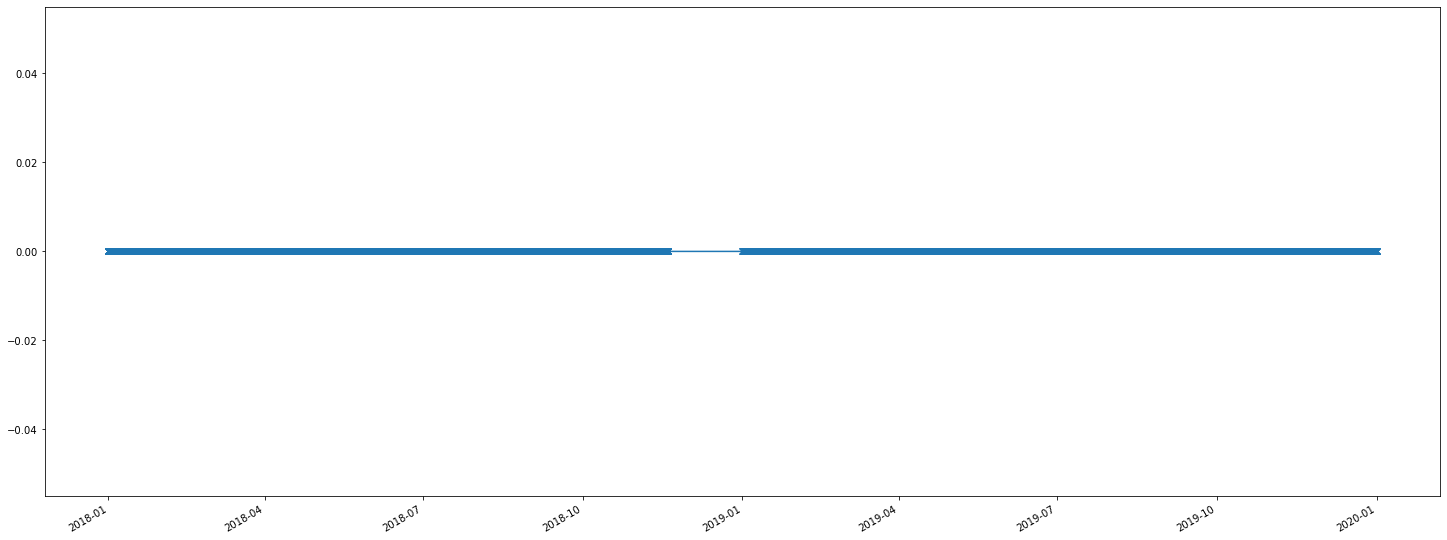

In [57]:
pd.Series(0, index=nwp_target_times).plot(marker='x');

In [58]:
sat_datetimes

DatetimeIndex(['2018-06-01 03:20:00', '2018-06-01 03:25:00',
               '2018-06-01 03:30:00', '2018-06-01 03:35:00',
               '2018-06-01 03:40:00', '2018-06-01 03:45:00',
               '2018-06-01 03:50:00', '2018-06-01 03:55:00',
               '2018-06-01 04:00:00', '2018-06-01 04:05:00',
               ...
               '2019-08-20 19:00:00', '2019-08-20 19:05:00',
               '2019-08-20 19:10:00', '2019-08-20 19:15:00',
               '2019-08-20 19:20:00', '2019-08-20 19:25:00',
               '2019-08-20 19:30:00', '2019-08-20 19:35:00',
               '2019-08-20 19:40:00', '2019-08-20 19:45:00'],
              dtype='datetime64[ns]', length=72385, freq=None)

In [59]:
sat_datetimes = sat_datetimes.intersection(nwp_target_times)
sat_datetimes

DatetimeIndex(['2018-06-01 03:20:00', '2018-06-01 03:25:00',
               '2018-06-01 03:30:00', '2018-06-01 03:35:00',
               '2018-06-01 03:40:00', '2018-06-01 03:45:00',
               '2018-06-01 03:50:00', '2018-06-01 03:55:00',
               '2018-06-01 04:00:00', '2018-06-01 04:05:00',
               ...
               '2019-08-20 19:00:00', '2019-08-20 19:05:00',
               '2019-08-20 19:10:00', '2019-08-20 19:15:00',
               '2019-08-20 19:20:00', '2019-08-20 19:25:00',
               '2019-08-20 19:30:00', '2019-08-20 19:35:00',
               '2019-08-20 19:40:00', '2019-08-20 19:45:00'],
              dtype='datetime64[ns]', length=67360, freq=None)

## Get contiguous segments

In [60]:
class Segment(NamedTuple):
    """Represents the start and end datetimes of a segment of contiguous samples.
    
    The Segment covers the range [start, end].
    """
    start: pd.Timestamp
    end: pd.Timestamp


def get_contiguous_segments(dt_index: pd.DatetimeIndex, min_timesteps: int, max_gap: pd.Timedelta) -> List[Segment]:
    """Chunk datetime index into contiguous segments, each at least min_timesteps long.
    
    max_gap defines the threshold for what constitutes a 'gap' between contiguous segments.
    
    Throw away any timesteps in a sequence shorter than min_timesteps long.
    """
    gap_mask = np.diff(dt_index) > max_gap
    gap_indices = np.argwhere(gap_mask)[:, 0]

    # gap_indicies are the indices into dt_index for the timestep immediately before the gap.
    # e.g. if the datetimes at 12:00, 12:05, 18:00, 18:05 then gap_indicies will be [1].
    segment_boundaries = gap_indices + 1

    # Capture the last segment of dt_index.
    segment_boundaries = np.concatenate((segment_boundaries, [len(dt_index)]))

    assert segment_boundaries[-2] != segment_boundaries[-1]
    
    segments = []
    start_i = 0
    for end_i in segment_boundaries:
        n_timesteps = end_i - start_i
        if n_timesteps >= min_timesteps:
            segment = Segment(start=dt_index[start_i], end=dt_index[end_i-1])
            segments.append(segment)
        start_i = end_i
        
    return segments

In [61]:
%%time
contiguous_segments = get_contiguous_segments(
    dt_index = sat_datetimes,
    min_timesteps = 36 * 1.5,
    max_gap = pd.Timedelta('5 minutes'))

contiguous_segments[:5]

CPU times: user 8.85 ms, sys: 0 ns, total: 8.85 ms
Wall time: 8.41 ms


[Segment(start=Timestamp('2018-06-01 03:20:00'), end=Timestamp('2018-06-01 21:00:00')),
 Segment(start=Timestamp('2018-06-02 03:20:00'), end=Timestamp('2018-06-02 21:05:00')),
 Segment(start=Timestamp('2018-06-03 03:20:00'), end=Timestamp('2018-06-03 21:05:00')),
 Segment(start=Timestamp('2018-06-04 03:20:00'), end=Timestamp('2018-06-04 21:05:00')),
 Segment(start=Timestamp('2018-06-05 03:20:00'), end=Timestamp('2018-06-05 21:05:00'))]

In [62]:
len(contiguous_segments)

420

## Turn the contiguous segments into sequences of Zarr chunks, which will be loaded together during training

In [63]:
def get_zarr_chunk_sequences(
    n_chunks_per_disk_load: int, 
    zarr_chunk_boundaries: List[datetime.datetime], 
    contiguous_segments: List[Segment]) -> List[Segment]:
    """
    
    Args:
      n_chunks_per_disk_load: Maximum number of Zarr chunks to load from disk in one go.
      zarr_chunk_boundaries: The datetime indicies into the Zarr store's time dimension which define the Zarr chunk boundaries.
        Must be sorted.
      contiguous_segments: Datetime indicies into the Zarr store's time dimension that define contiguous timeseries.
        That is, timeseries with no gaps.
    
    Returns zarr_chunk_sequences: a list of Segments representing the start and end datetimes of contiguous sequences of multiple Zarr chunks,
    all exactly n_chunks_per_disk_load long (for contiguous segments at least as long as n_chunks_per_disk_load zarr chunks),
    and at least one side of the boundary will lie on a 'natural' Zarr chunk boundary.
    
    For example, say that n_chunks_per_disk_load = 3, and the Zarr chunks sizes are all 5:
    
    
                  0    5   10   15   20   25   30   35 
                  |....|....|....|....|....|....|....|

    INPUTS:
                     |------CONTIGUOUS SEGMENT----|
                     
    zarr_chunk_boundaries:
                  |----|----|----|----|----|----|----|
    
    OUTPUT:
    zarr_chunk_sequences:
           3 to 15:  |-|----|----|
           5 to 20:    |----|----|----|
          10 to 25:         |----|----|----|
          15 to 30:              |----|----|----|
          20 to 32:                   |----|----|-|
    
    """
    assert n_chunks_per_disk_load > 0
    
    zarr_chunk_sequences = []

    for contig_segment in contiguous_segments:
        # searchsorted() returns the index into zarr_chunk_boundaries at which contig_segment.start
        # should be inserted into zarr_chunk_boundaries to maintain a sorted list.
        # i_of_first_zarr_chunk is the index to the element in zarr_chunk_boundaries which defines
        # the start of the current contig chunk.
        i_of_first_zarr_chunk = np.searchsorted(zarr_chunk_boundaries, contig_segment.start)
        
        # i_of_first_zarr_chunk will be too large by 1 unless contig_segment.start lies
        # exactly on a Zarr chunk boundary.  Hence we must subtract 1, or else we'll
        # end up with the first contig_chunk being 1 + n_chunks_per_disk_load chunks long.
        if zarr_chunk_boundaries[i_of_first_zarr_chunk] > contig_segment.start:
            i_of_first_zarr_chunk -= 1
            
        # Prepare for looping to create multiple Zarr chunk sequences for the current contig_segment.
        zarr_chunk_seq_start = contig_segment.start
        zarr_chunk_seq_end = None  # Just a convenience to allow us to break the while loop by checking if zarr_chunk_seq_end != contig_segment.end.
        while zarr_chunk_seq_end != contig_segment.end:
            zarr_chunk_seq_end = zarr_chunk_boundaries[i_of_first_zarr_chunk + n_chunks_per_disk_load]
            zarr_chunk_seq_end = min(zarr_chunk_seq_end, contig_segment.end)
            zarr_chunk_sequences.append(Segment(start=zarr_chunk_seq_start, end=zarr_chunk_seq_end))
            i_of_first_zarr_chunk += 1
            zarr_chunk_seq_start = zarr_chunk_boundaries[i_of_first_zarr_chunk]
            
    return zarr_chunk_sequences

In [64]:
zarr_chunk_sequences = get_zarr_chunk_sequences(
    n_chunks_per_disk_load=3,
    zarr_chunk_boundaries=zarr_chunk_boundaries,
    contiguous_segments=contiguous_segments)

zarr_chunk_sequences[:10]

[Segment(start=Timestamp('2018-06-01 03:20:00'), end=Timestamp('2018-06-01 11:05:00')),
 Segment(start=Timestamp('2018-06-01 05:05:00'), end=Timestamp('2018-06-01 14:05:00')),
 Segment(start=Timestamp('2018-06-01 08:05:00'), end=Timestamp('2018-06-01 17:05:00')),
 Segment(start=Timestamp('2018-06-01 11:05:00'), end=Timestamp('2018-06-01 20:05:00')),
 Segment(start=Timestamp('2018-06-01 14:05:00'), end=Timestamp('2018-06-01 21:00:00')),
 Segment(start=Timestamp('2018-06-02 03:20:00'), end=Timestamp('2018-06-02 11:55:00')),
 Segment(start=Timestamp('2018-06-02 05:55:00'), end=Timestamp('2018-06-02 14:55:00')),
 Segment(start=Timestamp('2018-06-02 08:55:00'), end=Timestamp('2018-06-02 17:55:00')),
 Segment(start=Timestamp('2018-06-02 11:55:00'), end=Timestamp('2018-06-02 20:55:00')),
 Segment(start=Timestamp('2018-06-02 14:55:00'), end=Timestamp('2018-06-02 21:05:00'))]

In [65]:
# Durations of zarr chunk sequences
[segment.end - segment.start for segment in zarr_chunk_sequences[:10]]

[Timedelta('0 days 07:45:00'),
 Timedelta('0 days 09:00:00'),
 Timedelta('0 days 09:00:00'),
 Timedelta('0 days 09:00:00'),
 Timedelta('0 days 06:55:00'),
 Timedelta('0 days 08:35:00'),
 Timedelta('0 days 09:00:00'),
 Timedelta('0 days 09:00:00'),
 Timedelta('0 days 09:00:00'),
 Timedelta('0 days 06:10:00')]

## PyTorch data storage & processing

In [66]:
Array = Union[np.ndarray, xr.DataArray]

IMAGE_ATTR_NAMES = ('sat_data', )

class Sample(TypedDict):
    """Simple class for structuring data for the ML model.
    
    Using typing.TypedDict gives us several advantages:
      1. Single 'source of truth' for the type and documentation of the fields in each example.
      2. A static type checker can check the types are correct.

    Instead of TypedDict, we could use typing.NamedTuple,
    which would provide runtime checks, but the deal-breaker with Tuples is that they're immutable
    so we cannot change the values in the transforms.
    """
    # IMAGES
    # Shape: batch_size, seq_length, width, height
    sat_data: Array
        
    # PV yield time series
    pv_yield: pd.Series
        
    # Numerical weather predictions (NWPs)
    nwp: Array  #: NWP covering the entire geographical extent.
    nwp_above_pv: Array  #: The NWP at a single point nearest to the PV system. TODO: Document shape.
    
    # METADATA
    forecast_len: int  #: Number of timesteps.
    history_len: int  #: Number of timesteps.
    pv_system_id: int
    pv_system_row_number: int  #: Guaranteed to be in the range [0, len(pv_metadata)]
    pv_location_x: float
    pv_location_y: float
    datetime_index: Array  #: At 5-minute timings like 00, 05, 10, ...; *not* the 04, 09, ... sequence of the satellite imagery.


class BadData(Exception):
    pass


@dataclass
class RandomSquareCrop():
    size: int = 128  #: Size (in pixels) of the cropped image.

    def __call__(self, sample: Sample) -> Sample:
        for attr_name in IMAGE_ATTR_NAMES:
            image = sample[attr_name]
            # TODO: Random crop!
            cropped_image = image[..., :self.size, :self.size]
            sample[attr_name] = cropped_image
        return sample


def crop_square(data_array: xr.DataArray, centre_x_osgb: float, centre_y_osgb: float, size_pixels: int):
    half_size_pixels = size_pixels // 2

    # centre_y_osgb and centre_x_osgb are in OSGB-space; but size_pixels is number of pixels!
    # Need to convert to integer index into image pixels.
    # The y array is in _descending_ order.
    centre_x_index = np.searchsorted(data_array.x, centre_x_osgb)
    centre_y_index = np.searchsorted(data_array.y[::-1], centre_y_osgb)
    centre_y_index = len(data_array.y) - centre_y_index
    
    # Get coordinates for boundaries of the cropped image.
    north = centre_y_index - half_size_pixels
    south = centre_y_index + half_size_pixels
    east = centre_x_index + half_size_pixels
    west = centre_x_index - half_size_pixels

    cropped = data_array.isel(
        x=slice(west, east), 
        y=slice(north, south))
    
    assert len(cropped.x) == size_pixels, len(cropped.x)
    assert len(cropped.y) == size_pixels, len(cropped.y)
    
    return cropped
    

@dataclass
class CropCentredOnPV():
    size_pixels: int = 128  #: Size (in pixels) of the cropped squaure image.  Must be an even number.
        
    def __post_init__(self):
        assert self.size_pixels % 2 == 0
    
    def __call__(self, sample: Sample) -> Sample:
        x = sample['pv_location_x']
        y = sample['pv_location_y']
        
        for attr_name in IMAGE_ATTR_NAMES:
            image = sample[attr_name]
            cropped_image = crop_square(image, x, y, self.size_pixels)
            sample[attr_name] = cropped_image
        return sample


class NWPAbovePV():
    def __call__(self, sample: Sample) -> Sample:
        # Now select data for nearest to PV system
        x = sample['pv_location_x']
        y = sample['pv_location_y']
        index = sample['datetime_index']
        start, end = index[0], index[-1]
        nwp_selected = sample['nwp'].sel(x=x, y=y, method='nearest')
        del sample['nwp']
        nwp_selected = nwp_selected.resample({'target_time': '5T'}).interpolate().astype(np.float32)
        nwp_selected = nwp_selected.sel(target_time=slice(start, end))
        sample['nwp_above_pv'] = nwp_selected
        return sample


class CheckForBadData():
    def __call__(self, sample: Sample) -> Sample:
        for attr_name in IMAGE_ATTR_NAMES:
            image = sample[attr_name]
            if np.any(image < 0):
                raise BadData(f'\n{attr_name} has negative values at {image.time.values}')
        return sample

        
class ToTensor():
    def __call__(self, sample: Sample) -> Sample:
        for key, value in sample.items():
            original_type = type(value)  # Helpful for debugging.
            if isinstance(value, (xr.DataArray, pd.Series, pd.DataFrame)):
                value = value.values
            elif isinstance(value, pd.DatetimeIndex):
                value = value.values.astype('datetime64[s]').astype(np.int64)
            elif isinstance(value, numbers.Number):
                value = np.asanyarray(value)
            
            try:
                sample[key] = torch.from_numpy(value)
            except:
                print(f'Failed to convert {key}, with value of type {original_type} = {value}')
                raise
        return sample
    
    
class Compose():
    # Copied from https://pytorch.org/vision/stable/_modules/torchvision/transforms/transforms.html#Compose
    # But not using torchvision, because it appears to create conda package conflicts
    # with opencv?  But need to explore more!
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

## PyTorch dataset

In [67]:
def get_nwp_example(
    nwp: xr.Dataset, 
    start: pd.Timestamp, 
    end: pd.Timestamp,
    t0: pd.Timestamp
    ) -> xr.Dataset:
    """Select the numerical weather predictions (NWP) for a single ML example.
    
    The NWP for each example covers a contiguous timespan running from `start` to `end`.
    The first part of the timeseries [`start`, `t0`] is the 'recent history'.
    The second part of the timeseries (`t0`, `end`] is the 'future'.
    
    For each timestep in the recent history [`start`, `t0`], get predictions 
    produced by the freshest NWP run to each timestep.
    
    For the future (`t0`, `end`], use the NWP initialised most recently to t0.
    
    Args:
      nwp: Numerical weather prediction Dataset.  Assumed to be hourly.
      start, end: The start and end datetimes of the entire example.
      t0_datetime: The datetime that represents 'now'.  That is, any datetimes <= 'now'
        are considered recent history; and datetimes > 'now' are considered forecast.
    """
    # First we get the hourly NWPs; then we resample to `freq` at the end of the function.
    
    # Ensure the datetimes are pd.Timestamps
    start = pd.Timestamp(start)
    end = pd.Timestamp(end)
    t0 = pd.Timestamp(t0)

    start_hourly = start.floor('H')
    t0_hourly = t0.ceil('H')
    end_hourly = end.ceil('H')
    
    target_times_hourly = pd.date_range(start_hourly, end_hourly, freq='H')
    
    # Get the most recent NWP initialisation time for each target_time_hourly.
    init_times = nwp.sel(init_time=target_times_hourly, method='ffill').init_time.values
    
    # Find the NWP init time for just the 'future' portion of the example.
    init_time_future = init_times[target_times_hourly == t0_hourly]
    
    # For the 'future' portion of the example, replace all the NWP init times with the
    # NWP init time most recent to t0.
    init_times[target_times_hourly > t0_hourly] = init_time_future
    
    # steps is the number of hourly timesteps beyond the NWP initialisation time.
    steps = target_times_hourly - init_times

    def _get_data_array_indexer(index):
        # We want one timestep for each target_time_hourly (obviously!)
        # If we simply do nwp.sel(init_time=init_times, step=steps)
        # then we'll get the *product* of init_times and steps,
        # which is not what we want!  Instead, we use xarray's vectorized-indexing mode
        # by using a DataArray indexer.  See the last example here:
        # http://xarray.pydata.org/en/stable/user-guide/indexing.html#vectorized-indexing
        return xr.DataArray(index, dims='target_time', coords={'target_time': target_times_hourly})
    
    init_time_indexer = _get_data_array_indexer(init_times)
    step_indexer = _get_data_array_indexer(steps)
    nwp_selected = nwp.sel(init_time=init_time_indexer, step=step_indexer)
    return nwp_selected

In [68]:
def get_nwp_example_b(nwp: xr.Dataset, start: pd.Timestamp, end: pd.Timestamp, t0: pd.Timestamp ) -> xr.Dataset: 
    """Select the numerical weather predictions (NWP) for a single ML example.

    The NWP for each example covers a contiguous timespan running from `start` to `end`.
    The first part of the timeseries [`start`, `t0`] is the 'recent history'.
    The second part of the timeseries (`t0`, `end`] is the 'future'.

    For each timestep in the recent history [`start`, `t0`], get predictions 
    produced by the freshest NWP run to each timestep.

    For the future (`t0`, `end`], use the NWP initialised most recently to t0.

    Args:
      nwp: Numerical weather prediction Dataset.  Assumed to be hourly.
      start, end: The start and end datetimes of the entire example.
      t0_datetime: The datetime that represents 'now'.  That is, any datetimes <= 'now'
        are considered recent history; and datetimes > 'now' are considered forecast.
    """
    # First we get the hourly NWPs; then we resample to `freq` at the end of the function.

    # Ensure the datetimes are pd.Timestamps
    start = pd.Timestamp(start)
    end = pd.Timestamp(end)
    #t0 = pd.Timestamp(t0)

    start_hourly = start.floor('H')
    #t0_hourly = t0.ceil('H')
    end_hourly = end.ceil('H')

    #target_times_hourly = pd.date_range(start_hourly, end_hourly, freq='H')

    # Get the most recent NWP initialisation time for each target_time_hourly.
    #init_time_indices = np.searchsorted(nwp.init_time, start_hourly.to_datetime64())
    #init_time = nwp.init_time[init_time_indices].values
    #init_time = nwp.init_time.values[0]
    nwp = nwp.sel(init_time=start_hourly, method='ffill')
    init_time = nwp.init_time.values
    #print(nwp.init_time)
    #nwp['target_time'] = nwp.init_time + nwp.step
    #nwp = nwp.swap_dims({'step': 'target_time'})

    # steps is the number of hourly timesteps beyond the NWP initialisation time.
    # steps = target_times_hourly - init_time

    nwp_selected = nwp.sel(step=slice(
        start_hourly - init_time, 
        end_hourly - init_time
    ))
    
    return nwp_selected

In [69]:
# Test!

#selected_nwp = get_nwp_example(
#    nwp.sel(init_time=slice(pd.Timestamp('2019-04-28T06:00:00'), pd.Timestamp('2019-04-28T12:00:00'))).to_array(),
#    start=pd.Timestamp('2019-04-28T06:25:00'),
#    end=pd.Timestamp('2019-04-28 06:35:00'),
#    t0=pd.Timestamp('2019-04-28 06:30:00')
#)

#start=2019-04-28T06:25:00.000000000, end=2019-04-28 06:35:00, t0=2019-04-28 06:30:00

#selected_nwp

In [70]:
# del nwp, sat_data

In [71]:
class DataInMemory():
    """Abstract base class used for getting a training Sample from in-memory data."""

    def get_sample(self, start: datetime.datetime, end: datetime.datetime, t0: datetime.datetime) -> Sample:
        raise NotImplemented()


class AsyncDataLoader():
    """Abstract base class."""

    def per_worker_init(self) -> None:
        """Optionally, can be overridden by child classes."""
        pass

    def async_load(self, executor: futures.Executor, selected_zarr_chunk_sequences: List[Segment]) -> List[futures.Future]:
        """Non-blocking.  Must be overridden by child classes.

        Asynchronously and in parallel loads data for all selected_zarr_chunk_sequences.

        Returns:
          List of futures, one per selected_zarr_chunk_sequence.
          Calling future.result() will get back an instance of a concrete child class of InMemoryData.
        """
        future_data_per_chunk = []
        for segment in selected_zarr_chunk_sequences:
            future_data = executor.submit(self.load_single_chunk, segment)
            future_data_per_chunk.append(future_data)
        return future_data_per_chunk

    def load_single_chunk(self, segment: Segment) -> DataInMemory:
        """Must be overridden."""
        raise NotImplemented()

In [72]:
@dataclass
class SatelliteDataInMemory(DataInMemory):
    sat_data_in_mem: xr.DataArray

    def get_sample(self, start: datetime.datetime, end: datetime.datetime, t0: datetime.datetime) -> Sample:
        del t0  # Not used in this method.
        selected_sat_data = self.sat_data_in_mem.sel(time=slice(start, end))
        return Sample(sat_data=selected_sat_data)


class SatelliteDataLoader(AsyncDataLoader):
    def per_worker_init(self) -> None:
        self.sat_data = open_sat_data()
    
    def load_single_chunk(self, segment: Segment) -> SatelliteDataInMemory:
        start, end = segment
        sat_data = self.sat_data.sel(time=slice(start, end))
        sat_data_in_mem = sat_data.compute()
        return SatelliteDataInMemory(sat_data_in_mem=sat_data_in_mem)

In [73]:
pv_power_df = pv_power_df.loc[sat_datetimes]

In [74]:
pv_power_df = pv_power_df.astype(np.float16)

In [75]:
@dataclass
class PVDataInMemory(DataInMemory):
    pv_power_df: pd.DataFrame #: PV yield, resampled to 5-minutely
    pv_metadata: pd.DataFrame 
        
    def __post_init__(self):
        seed = torch.initial_seed()
        self.rng = np.random.default_rng(seed=seed)

    def get_sample(self, start: datetime.datetime, end: datetime.datetime, t0: datetime.datetime) -> Sample:
        del t0  # Not used in this method.
        selected_pv_power_df = self.pv_power_df.loc[start:end]
        
        # Select just one PV system
        selected_pv_power_df = selected_pv_power_df.dropna(axis='columns', how='any')
        pv_system_ids = selected_pv_power_df.columns
        pv_system_id = self.rng.choice(pv_system_ids)
        selected_pv_power = selected_pv_power_df[pv_system_id]
        
        # Get metadata for PV system
        metadata_for_pv_system = self.pv_metadata.loc[pv_system_id]
        
        # Save data into the Sample dict...
        return Sample(
            pv_system_id=pv_system_id,
            pv_system_row_number=self.pv_metadata.index.get_loc(pv_system_id),
            pv_yield=selected_pv_power,
            pv_location_x=metadata_for_pv_system.location_x,
            pv_location_y=metadata_for_pv_system.location_y)


@dataclass
class PVDataLoader(AsyncDataLoader):
    """Data Loader for PV power data.
    
    Unlike SatelliteDataLoader and NWPDataLoader, PVDataLoader doesn't actually load any data
    from disk because the PV power data is small enough to keep all the data in memory :).
    But `load_single_chunk` still needs needs to select a subset of the PV data, so we don't
    end up using an insane amount of RAM with copies of the PV data :)
    """
    pv_power_df: pd.DataFrame = pv_power_df.astype(np.float16)  #: PV yield, resampled to 5-minutely
    pv_metadata: pd.DataFrame = pv_metadata
    
    def load_single_chunk(self, segment: Segment) -> PVDataInMemory:
        start, end = segment
        pv_data_selected = pv_power_df.loc[start:end].dropna(axis='columns', how='any')
        return PVDataInMemory(pv_power_df=pv_data_selected, pv_metadata=self.pv_metadata)

In [76]:
# TODO: Add border?

PV_EAST_BOUND = pv_metadata.location_x.min()
PV_WEST_BOUND = pv_metadata.location_x.max()
PV_NORTH_BOUND = pv_metadata.location_y.max()
PV_SOUTH_BOUND = pv_metadata.location_y.min()

PV_EAST_BOUND, PV_WEST_BOUND, PV_NORTH_BOUND, PV_SOUTH_BOUND

(59576.949737831834, 651572.0589233699, 1021136.4906935596, 15407.121801329937)

In [77]:
ABSOLUTE_ZERO_CELSIUS = -273.15
MIN_TEMPERATURE_CELSIUS = -50
MAX_TEMPERATURE_CELSIUS = 50
RANGE_TEMPERATURE_CELSIUS = MAX_TEMPERATURE_CELSIUS - MIN_TEMPERATURE_CELSIUS

def temperature_kelvin_to_unit8(temperature_kelvin: Array) -> Array:
    temperature_celsius = temperature_kelvin + ABSOLUTE_ZERO_CELSIUS
    temperature_scaled_zero_to_one = (temperature_celsius - MIN_TEMPERATURE_CELSIUS) / RANGE_TEMPERATURE_CELSIUS
    temperature_8bit = (temperature_scaled_zero_to_one * 255).round().astype(np.uint8)
    return temperature_8bit

In [78]:
@dataclass
class NWPDataInMemory(DataInMemory):
    nwp_in_mem: xr.DataArray
    
    def get_sample(self, start: datetime.datetime, end: datetime.datetime, t0: datetime.datetime) -> Sample:
        try:
            selected_nwp = get_nwp_example(self.nwp_in_mem, start=start, end=end, t0=t0)
            #selected_nwp = selected_nwp.swap_dims({'step': 'target_time'})
        except:
            print(f'Failed to get_sample for NWP.  start={start}, end={end}, t0={t0}, self.nwp_in_mem.init_time={self.nwp_in_mem.init_time}')
            raise
        return Sample(nwp=selected_nwp)


@dataclass
class NWPDataLoader(AsyncDataLoader):
    params: Iterable[str] = (
        't',  # Temperature in Kelvin.
        #'dswrf',  # Downward short-wave radiation flux in W/m2 (irradiance).
        #'prate',  # Precipitation rate in kg m^-2 s^-1.
        #'r',  # Relative humidty in %.
        #'sde',  # Snow depth in meters.
        #'si10',  # 10-meter wind speed in m/s.
        #'vis',  # Visibility in meters.
        #'lcc',  # Low-level cloud cover in %.
        #'mcc',  # Medium-level cloud cover in %.
        #'hcc',  # High-level cloud cover in %.
    )
        
    def per_worker_init(self) -> None:
        self.nwp = open_nwp()
        params = list(self.params)
        
        # Scale to minimal data types, to save memory
        if 't' in params:
            self.nwp['t'] = temperature_kelvin_to_unit8(self.nwp['t'])
        
        self.nwp = self.nwp[params].to_array()
        #self.nwp = self.nwp.transpose('step', 'init_time', ...)
        
    def load_single_chunk(self, segment: Segment) -> NWPDataInMemory:
        start, end = segment
        
        # The UKV NWP is only initialised every 3 hours,
        # so make sure we get all the data we need for get_sample().
        start = start - pd.Timedelta('3H')
        end = end + pd.Timedelta('3H')

        nwp_data = self.nwp.sel(
            init_time=slice(start, end),
            x=slice(PV_EAST_BOUND, PV_WEST_BOUND),  # Save memory by only taking bits we care about
            y=slice(PV_NORTH_BOUND, PV_SOUTH_BOUND)
        )
        nwp_data = nwp_data.isel(step=slice(0, MAX_STEP + 1))
        #nwp_data['target_time'] = nwp_data.init_time + nwp_data.step
        nwp_data = nwp_data.compute()
        return NWPDataInMemory(nwp_in_mem=nwp_data)

In [79]:
#nwp_loader = NWPDataLoader()
#nwp_loader.per_worker_init()

In [80]:
%%time
#nwp_in_mem = nwp_loader.load_single_chunk(contiguous_segments[0])

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


In [81]:
#nwp_in_mem.nwp_in_mem.nbytes / 1E6

In [82]:
%%time
#nwp_selected = nwp_in_mem.get_sample(
#    pd.Timestamp('2018-06-01T03:00'), 
#    pd.Timestamp('2018-06-01T03:10'), 
#    pd.Timestamp('2018-06-01T03:05')
#)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


In [83]:
#nwp_selected['nwp'].nbytes / 1E6

In [84]:
%%time
#sat_loader = SatelliteDataLoader()
#sat_loader.per_worker_init()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


In [85]:
#sat_in_mem = sat_loader.load_single_chunk(contiguous_segments[0])

In [86]:
#sat_in_mem.sat_data_in_mem.nbytes / 1E6

In [87]:
%%time
#_ = sat_in_mem.get_sample(
#    pd.Timestamp('2018-06-01T03:00'), 
#    pd.Timestamp('2018-06-01T03:10'), 
#    pd.Timestamp('2018-06-01T03:05')
#)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.77 µs


In [88]:
#del nwp_loader, nwp_in_mem

In [89]:
@dataclass
class NowcastingDataset(torch.utils.data.IterableDataset):
    """Orchestrates DataSources."""
    zarr_chunk_sequences: Iterable[Segment]  #: Defines multiple Zarr chunks to be loaded from disk at once.
    history_len: int = 1  #: The number of timesteps of 'history' to load.  Must by larger than 0.  This includes t0.  So, if history_len == 1, then the only 'history' will be t0.
    forecast_len: int = 1  #: The number of timesteps of 'forecast' to load.

    async_data_loaders: Iterable[AsyncDataLoader] = (SatelliteDataLoader(), PVDataLoader(), NWPDataLoader())
    transform: Optional[Callable] = None

    n_disk_loads_per_epoch: int = 10_000  #: Number of disk loads per worker process per epoch.
    min_n_samples_per_disk_load: int = 4_000  #: Number of samples each worker will load for each disk load.
    max_n_samples_per_disk_load: int = 8_000  #: Max number of disk loader.  Actual number is chosen randomly between min & max.
    n_zarr_chunk_sequences_to_load_at_once: int = 8  #: Number of chunk seqs to load at once.  These are sampled at random.
    
    def __post_init__(self):
        #: Total sequence length of each sample, in terms of number of timesteps.
        assert self.history_len > 0
        self.total_seq_len = self.history_len + self.forecast_len
        total_seq_minutes = self.total_seq_len * 5
        self.total_seq_timedelta = pd.Timedelta(total_seq_minutes, unit='minutes')

    def per_worker_init(self) -> None:
        """Called by worker_init_fn on each copy of NowcastingDataset after the worker process has been spawned."""       
        # Each worker must have a different seed for its random number generator.
        # Otherwise all the workers will output exactly the same data!
        seed = torch.initial_seed()
        self.rng = np.random.default_rng(seed=seed)
        for async_data_loader in self.async_data_loaders:
            async_data_loader.per_worker_init()

    def __iter__(self):
        """Asynchronously loads next data from disk while sampling from data in memory."""
        with futures.ThreadPoolExecutor() as executor:
            future_data_loaders, selected_zarr_chunk_sequences = self._async_load(executor)
            for _ in range(self.n_disk_loads_per_epoch):
                in_mem_data_from_asyc_loaders = [
                    [future.result() for future in future_data_per_chunk]
                    for future_data_per_chunk in future_data_loaders]
                future_data_loaders, next_selected_zarr_chunk_sequences = self._async_load(executor)
                # Pick a random number of samples to sample from one disk load.
                # We do this so that the worker processes don't all try to load from disk at the same time.
                n_samples = self.rng.integers(self.min_n_samples_per_disk_load, self.max_n_samples_per_disk_load)
                print('threading.active_count', threading.active_count())
                for _ in range(n_samples):
                    # Randomly select chunk_i, start_time and end_time.
                    chunk_i = self.rng.integers(0, self.n_zarr_chunk_sequences_to_load_at_once)
                    segment = selected_zarr_chunk_sequences[chunk_i]
                    start_time = self._get_random_start_time(segment)
                    # Subtract 1 timestep (5 minutes) from end_time because .loc[start:end] includes the start and end,
                    # so will give us 1 extra timestep!
                    end_time = start_time + self.total_seq_timedelta - pd.Timedelta('5 minutes')
                    datetime_index = pd.date_range(start_time, end_time, freq='5T')
                    t0 = datetime_index[self.history_len - 0]

                    # Initialise Sample.  Sample will be updated with more data in the next code block.
                    sample = Sample(
                        datetime_index=datetime_index,
                        history_len=self.history_len,
                        forecast_len=self.forecast_len)
                    
                    # Collect data from AsyncDataLoaders.
                    # TODO: Could use multiple threads to load data from all the async_loaders in parallel,
                    # but that's probably not helpful because this loop is probably CPU-bound.
                    for in_mem_data_per_chunk in in_mem_data_from_asyc_loaders:
                        in_mem_data = in_mem_data_per_chunk[chunk_i]
                        try:
                            new_sample = in_mem_data.get_sample(start_time, end_time, t0)
                        except:
                            print(f'Failed get_sample.  segment={segment}')
                            raise
                        sample.update(new_sample)
                        del new_sample, in_mem_data, in_mem_data_per_chunk
                        
                    # Transform.
                    if self.transform:
                        try:
                            sample = self.transform(sample)
                        except BadData as e:
                            # print(e)
                            continue

                    yield sample
                    del sample

                # Prepare for next iteration.
                selected_zarr_chunk_sequences = next_selected_zarr_chunk_sequences

    def _async_load(self, executor: futures.Executor) -> Tuple[List[List[futures.Future]], List[Segment]]:
        """Loads data from contiguous Zarr chunks from disk into memory.  Non-blocking.
        
        Returns: future_data, selected_zarr_chunk_sequences
          future_data:  A list of list of futures.Future objects(!).
            The outer list is one per self.async_data_loader.
            The inner list is one per Zarr chunk. Calling future.result() will return the InMemoryData object.
        """
        selected_zarr_chunk_sequences = self._select_zarr_chunk_sequences()
        future_data: List[futures.Future] = []
        for async_data_loader in self.async_data_loaders:
            future_data_for_loader = async_data_loader.async_load(executor, selected_zarr_chunk_sequences)
            future_data.append(future_data_for_loader)
        return future_data, selected_zarr_chunk_sequences

    def _select_zarr_chunk_sequences(self) -> List[Segment]:
        selected_zarr_chunk_sequences = []
        for _ in range(self.n_zarr_chunk_sequences_to_load_at_once):
            zarr_chunk_sequence = self.rng.choice(self.zarr_chunk_sequences)
            # Weirdly, rng.choice converts the Segment to a 2-element ndarray.  
            # So let's convert back to a Segment:
            zarr_chunk_sequence = Segment(*zarr_chunk_sequence)
            selected_zarr_chunk_sequences.append(zarr_chunk_sequence)
        return selected_zarr_chunk_sequences
    
    def _get_random_start_time(self, segment: Segment) -> datetime.datetime:
        max_start_time = segment.end - self.total_seq_timedelta
        poss_start_times = pd.date_range(segment.start, max_start_time, freq='5T')
        return self.rng.choice(poss_start_times)


def worker_init_fn(worker_id):
    """Configures each dataset worker process.
    
    Just has one job!  To call SatelliteDataset.per_worker_init().
    """
    # get_worker_info() returns information specific to each worker process.
    worker_info = torch.utils.data.get_worker_info()
    if worker_info is None:
        print('worker_info is None!')
    else:
        dataset_obj = worker_info.dataset  # The Dataset copy in this worker process.
        dataset_obj.per_worker_init()

### Testing

In [90]:
#dataset_without_to_tensor = SatelliteDataset(
#    zarr_chunk_sequences=zarr_chunk_sequences,
#    transform=Compose([
#        CropCentredOnPv(),
#        CheckForBadData(),
#    ]),
#)

In [91]:
#dataset_without_to_tensor.per_worker_init()

In [92]:
#dataset_iter = dataset_without_to_tensor.__iter__()

In [93]:
#sample = next(dataset_iter)

In [94]:
#fig, axes = plt.subplots(nrows=3, figsize=(10, 20))

#ax = axes[0]
#sample['historical_sat_images'].isel(time=0).plot(ax=ax)
#ax.scatter(sample['pv_location_x'], sample['pv_location_y'], c='black')

#ax = axes[1]
#sample['target_sat_images'].isel(time=0).plot(ax=ax)
#ax.scatter(sample['pv_location_x'], sample['pv_location_y'], c='black')

#ax = axes[2]
#ax.plot(pd.concat((sample['historical_pv_yield'], sample['target_pv_yield'])))

In [95]:
#sample['nwp_above_pv'].sel(variable='t').plot()

In [96]:
def get_dataloader(num_workers: int):

    torch.manual_seed(42)

    dataset = NowcastingDataset(
        zarr_chunk_sequences=zarr_chunk_sequences,
        transform=Compose([
            CropCentredOnPV(),
            NWPAbovePV(),
            CheckForBadData(),
            ToTensor(),
        ]),
    )

    if num_workers == 0:
        dataset.per_worker_init()

    return torch.utils.data.DataLoader(
        dataset,
        batch_size=8,
        num_workers=num_workers,  # timings:  4=13.8s; 8=11.6; 10=11.3s; 11=11.5s; 12=12.6s.  10=3it/s
        worker_init_fn=worker_init_fn,
        pin_memory=True,
        #multiprocessing_context='spawn'
        persistent_workers=False # num_workers > 0
    )

dataloader = get_dataloader(num_workers=12)

In [97]:
%%time
#for batch in dataloader:
#    print(batch['sat_data'].shape)
#    break

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.48 µs


In [98]:
#batch['sat_data'].numpy().nbytes / 1E6

In [99]:
#pd.to_datetime(batch['datetime_index'].numpy().flatten(), unit='s').values.reshape(-1, 2).astype('datetime64[s]')

In [100]:
#batch['historical_sat_images'].shape

In [101]:
#batch['target_sat_images'].shape

In [102]:
#batch['historical_sat_images'].dtype

In [103]:
#plt.imshow(batch['historical_sat_images'][0, 0])

In [104]:
#plt.imshow(batch['target_sat_images'][0, 0])

In [105]:
#batch['pv_yield'].shape

In [106]:
#batch['nwp_above_pv'].shape

In [107]:
#batch['nwp_above_pv']

# Simple ML model

In [108]:
def normalise_images_in_model(images, device):    
    SAT_IMAGE_MEAN = torch.tensor(93.23458, dtype=torch.float, device=device)
    SAT_IMAGE_STD = torch.tensor(115.34247, dtype=torch.float, device=device)
    
    images = images.float()
    images -= SAT_IMAGE_MEAN
    images /= SAT_IMAGE_STD
    return images

In [109]:
CHANNELS = 32
KERNEL = 3


class LitAutoEncoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.encoder_conv1 = nn.Conv2d(in_channels=1, out_channels=CHANNELS//2, kernel_size=KERNEL)
        self.encoder_conv2 = nn.Conv2d(in_channels=CHANNELS//2, out_channels=CHANNELS, kernel_size=KERNEL)
        self.encoder_conv3 = nn.Conv2d(in_channels=CHANNELS, out_channels=CHANNELS, kernel_size=KERNEL)

        self.maxpool = nn.MaxPool2d(kernel_size=KERNEL)
        
        self.fc1 = nn.Linear(
            in_features=CHANNELS * 11 * 11, 
            out_features=256 - 5  # Minus 5 (1 for the NWP temperature above the PV system; 4 for the PV system embedding)
        )
        #self.fc_just_prev_yield = nn.Linear(in_features=1, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=128)
        self.fc4 = nn.Linear(in_features=128, out_features=128)
        self.fc5 = nn.Linear(in_features=128, out_features=1)
        
        self.pv_system_id_embedding = nn.Embedding(
            num_embeddings=len(pv_metadata),
            embedding_dim=4
        )
        
    def forward(self, x):
        history_len = x['history_len'][0]  # Assume very example in the batch has same history len!
        images = x['sat_data'][:, history_len:]
        images = normalise_images_in_model(images, self.device)
        
        # Pass data through the network :)
        out = F.relu(self.encoder_conv1(images))
        out = self.maxpool(out)
        out = F.relu(self.encoder_conv2(out))
        out = self.maxpool(out)
        out = F.relu(self.encoder_conv3(out))
        
        out = out.view(-1, CHANNELS * 11 * 11)
        out = F.relu(self.fc1(out))
        
        pv_embedding = self.pv_system_id_embedding(x['pv_system_row_number'])
        
        out = torch.cat(
            (
                out, 
                #x['historical_pv_yield'][:, :1],
                (x['nwp_above_pv'][:, 0, history_len:].float() - 130) / 5,  # TODO fix horrible standardisation of temperature!
                pv_embedding
            ), dim=1)

        #out = F.relu(self.fc_just_prev_yield(x['historical_pv_yield'][:, :1]))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = F.relu(self.fc4(out))
        out = self.fc5(out)

        return out
    
    def _training_or_validation_step(self, batch, is_train_step):
        y_hat = self(batch)
        history_len = batch['history_len'][0]  # Assume very example in the batch has same history len!
        y = batch['pv_yield'][:, history_len:]
        #mse_loss = F.mse_loss(y_hat, y)
        mae_loss = (y_hat - y).abs().mean()
        tag = "Train" if is_train_step else "Validation"
        #self.log_dict({'MSE/' + tag: mse_loss}, on_step=is_train_step, on_epoch=True)
        self.log_dict({'MAE/' + tag: mae_loss}, on_step=is_train_step, on_epoch=True)
        return mae_loss

    def training_step(self, batch, batch_idx):
        return self._training_or_validation_step(batch, is_train_step=True)
    
    def validation_step(self, batch, batch_idx):
        return self._training_or_validation_step(batch, is_train_step=False)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [110]:
model = LitAutoEncoder()

In [111]:
#model(batch).shape

In [112]:
trainer = pl.Trainer(gpus=1, max_epochs=400, terminate_on_nan=False)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [113]:
%%time
trainer.fit(model, train_dataloader=dataloader)

/home/jack/miniconda3/envs/predict_pv_yield/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type      | Params
-----------------------------------------------------
0 | encoder_conv1          | Conv2d    | 160   
1 | encoder_conv2          | Conv2d    | 4.6 K 
2 | encoder_conv3          | Conv2d    | 9.2 K 
3 | maxpool                | MaxPool2d | 0     
4 | fc1                    | Linear    | 972 K 
5 | fc2                    | Linear    | 32.9 K
6 | fc3                    | Linear    | 16.5 K
7 | fc4                    | Linear    | 16.5 K
8 | fc5                    | Linear    | 129   
9 | pv_system_id_embedding | Embedding | 3.8 K 
-----------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params

Epoch 0: : 0it [00:00, ?it/s]              threading.active_count 91
threading.active_countthreading.active_countthreading.active_count  threading.active_count 94 9594
95


threading.active_count 101
threading.active_count 89
threading.active_count 96
threading.active_count 96
threading.active_count 99
threading.active_count 94
threading.active_count 92
Epoch 0: : 6194it [02:43, 37.81it/s, loss=0.106, v_num=256] threading.active_count 116
Epoch 0: : 7283it [03:05, 39.18it/s, loss=0.123, v_num=256] threading.active_count 118
Epoch 0: : 7607it [03:13, 39.41it/s, loss=0.121, v_num=256] threading.active_count 118
Epoch 0: : 9030it [03:42, 40.67it/s, loss=0.107, v_num=256] threading.active_count 120
Epoch 0: : 9445it [03:51, 40.86it/s, loss=0.13, v_num=256]  threading.active_count 118
Epoch 0: : 9728it [03:57, 40.91it/s, loss=0.101, v_num=256] threading.active_count 120
Epoch 0: : 9834it [04:00, 40.86it/s, loss=0.121, v_num=256] threading.active_count 116
Epoch 0: : 10366it [04:12, 41.09it/

Exception in thread Thread-7:
Traceback (most recent call last):
  File "/home/jack/miniconda3/envs/predict_pv_yield/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/jack/miniconda3/envs/predict_pv_yield/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jack/miniconda3/envs/predict_pv_yield/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 25, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/home/jack/miniconda3/envs/predict_pv_yield/lib/python3.8/multiprocessing/queues.py", line 116, in get
    return _ForkingPickler.loads(res)
  File "/home/jack/miniconda3/envs/predict_pv_yield/lib/python3.8/site-packages/torch/multiprocessing/reductions.py", line 282, in rebuild_storage_fd
    fd = df.detach()
  File "/home/jack/miniconda3/envs/predict_pv_yield/lib/python3.8/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_

RuntimeError: DataLoader worker (pid(s) 57772) exited unexpectedly